Let's try loading dataset and running logistical regression since this is choice modelling.

In [2]:
%matplotlib inline
from __future__ import division
import pandas as pd
import numpy as np
from seaborn import plt
import statsmodels.api as sm

filename = './FraudDataSet.xlsx'
df_data = pd.read_excel(filename)
#re-order columns
df_data = df_data[['Acct', 'Sequence', 'ZIP', 'MCC', 'Fraud', 'AMT']]
df_data.head()

,Acct,Sequence,ZIP,MCC,Fraud,AMT
0,4321560000001849,1,94463,5464,False,16.40
1,4321560000009502,2,94476,5438,False,176.45
2,4321560000007353,3,94411,5478,False,81.79
3,4321560000002807,4,94429,5437,False,146.24
4,4321560000003364,5,94402,5461,False,105.83


About the Data:
500 Rows with Dummy card numbers along with a unique sequence ID for all the transactions against them. Transaction attributes/columns include the Zip Code, Merchant Category code, Amount involved in the transaction and whether the transaction was Fraud or not.

In [3]:
#Converting the 3 Categorical variables Zip, MCC, and Acct to dummy/indicator variables 
#and adding them to the dataframe
df_data = pd.concat([df_data, pd.get_dummies(df_data['ZIP'], prefix='Zip')], axis=1)
df_data = pd.concat([df_data, pd.get_dummies(df_data['MCC'], prefix='MCC')], axis=1)
df_data = pd.concat([df_data, pd.get_dummies(df_data['Acct'], prefix='Acct')], axis=1)
df_data.shape

(500, 675)

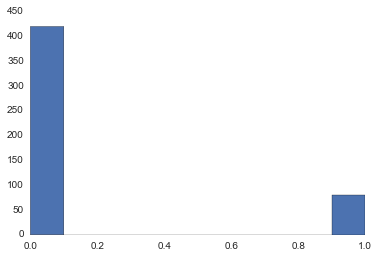

In [4]:
#Set 0 if Fraud is False else 1
df_data['Fraud'] = df_data['Fraud'].apply(lambda x: 1 if x else 0)
df_data['Fraud'].hist()

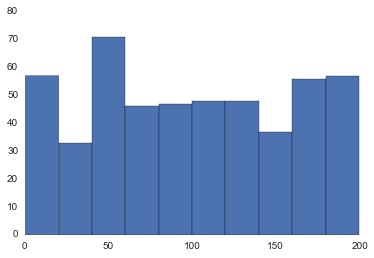

In [5]:
#Just visualizing how amount looks like and if it needs any transformations.
df_data['AMT'].hist()

In [6]:
#Setting the target dependnent variable Y and input independent variables X
df_y = df_data['Fraud']
df_x = df_data.ix[:,5:]
print df_y.shape
print df_x.shape

(500,)
(500, 670)


In [7]:
#Running the Logistic regression model on above results in error due to
#Too many categorical variables that lead to High dimensionality and collinearity problem. 
#So Reducing dimensions using PCA to understand the model better

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3, whiten=True)
pca.fit(df_x.values)

PCA(copy=True, n_components=3, whiten=True)

In [9]:
pca.components_
pca.components_.shape

(3, 670)

In [10]:
pca.explained_variance_ratio_

array([  9.99139370e-01,   3.93569836e-05,   2.16993746e-05])

In [11]:
pca.explained_variance_ratio_.sum()

0.99920042652418783

99.91 % of the variance in the data is explained by the 3 components and the first components contributes the highest towards the variance explanation.

In [12]:
#Transforming the input values using the PCA object to conform to it.
x_pca = pca.transform(df_x.values)

In [13]:
df_x_pca = pd.DataFrame(x_pca, columns=['PC1', 'PC2', 'PC3'])
df_x_pca.head()

,PC1,PC2,PC3
0,1.428026,0.765187,0.067347
1,-1.311901,-0.107812,-0.507417
2,0.308600,0.402414,-0.151684
3,-0.794733,0.078233,-0.448306
4,-0.102946,0.289364,-0.175015


In [14]:
#Adding the constant was not really improving the model. Using 3 components improves the model
#df_x_pca = sm.add_constant(df_x_pca)
logit_regression = sm.Logit(df_y, df_x_pca)
result = logit_regression.fit()
print result.summary()

Optimization terminated successfully.
         Current function value: 0.586756
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  Fraud   No. Observations:                  500
Model:                          Logit   Df Residuals:                      497
Method:                           MLE   Df Model:                            2
Date:                Sun, 15 Mar 2015   Pseudo R-squ.:                 -0.3345
Time:                        09:26:17   Log-Likelihood:                -293.38
converged:                       True   LL-Null:                       -219.83
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
PC1           -0.4392      0.128     -3.436      0.001        -0.690    -0.189
PC2           -0.3342      0.

In [15]:
#Creating a new dataframe for results of the model predictions
df_y_predict = pd.DataFrame()
#Loading existing Fraud results
df_y_predict['Fraud_Result'] = df_data['Fraud']
#Loading the predicted fraud results from the model
df_y_predict['Fraud_Prob'] = result.predict(df_x_pca)
print df_y_predict.head()

   Fraud_Result  Fraud_Prob
0             0    0.338594
1             0    0.269790
2             0    0.320665
3             0    0.250169
4             0    0.352949


In [16]:
df_y_predict['Fraud_Predicted'] = np.nan
#Taking a 50% Threshold for predictions
df_y_predict.ix[df_y_predict['Fraud_Prob'] >0.50,'Fraud_Predicted'] = 1
df_y_predict.ix[df_y_predict['Fraud_Prob'] <=0.50,'Fraud_Predicted'] = 0
print df_y_predict[df_y_predict['Fraud_Predicted'] ==1].head(10)

    Fraud_Result  Fraud_Prob  Fraud_Predicted
6              1    0.647489                1
7              0    0.999417                1
12             1    1.000000                1
18             1    0.642884                1
24             1    1.000000                1
30             0    0.999612                1
32             0    0.640087                1
40             1    0.739269                1
43             1    1.000000                1
46             1    1.000000                1


In [17]:
from sklearn import metrics
print metrics.confusion_matrix(df_y_predict['Fraud_Result'], df_y_predict['Fraud_Predicted'])

[[388  32]
 [ 48  32]]


In [18]:
print metrics.classification_report(df_y_predict['Fraud_Result'], df_y_predict['Fraud_Predicted'])

             precision    recall  f1-score   support

          0       0.89      0.92      0.91       420
          1       0.50      0.40      0.44        80

avg / total       0.83      0.84      0.83       500



In [19]:
from sklearn import metrics
metrics.accuracy_score(df_y_predict['Fraud_Result'], df_y_predict['Fraud_Predicted'])

0.83999999999999997

That's 84% accuracy w.r.t to our predicted values matching our real world results data set.

Cross Validate to see if that predictive accuracy holds for Logistic Regression

In [20]:
#Reload our transformed original data again
df_y = df_data['Fraud']
df_x = df_data.ix[:,5:]
print df_y.shape
print df_x.shape

(500,)
(500, 670)


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.preprocessing import scale

#Create the training (and test) set using scikit-learn's train_test_split function
x_train, x_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=12)
print x_train.shape
print y_train.shape
print x_test.shape
print y_test.shape

(350, 670)
(350,)
(150, 670)
(150,)


In [25]:
#Using a logistic regression model from scikit learn to fit with X and y
logistic_model = LogisticRegression()
logistic_model = logistic_model.fit(x_train, y_train)

#Checking the accuracy on the training set
logistic_model.score(x_train, y_train)

0.9028571428571428

In [26]:
#Checking the accuracy on the test set
logistic_model.score(x_test, y_test)

0.88

In [27]:
#Checking mean accuracy with Cross Validation on the test set using 10 Fold Cross Validation
scores = cross_val_score(logistic_model, x_test, y_test, cv=10)
print scores
print "Mean Accuracy on our overall data set using Logistic Regression = %0.2f" % (scores.mean()*100)

[ 0.8125      0.86666667  0.86666667  0.86666667  0.86666667  0.86666667
  0.86666667  0.86666667  0.86666667  0.85714286]
Mean Accuracy on our overall data set using Logistic Regression = 86.03


Let's try KNN for the heck of it

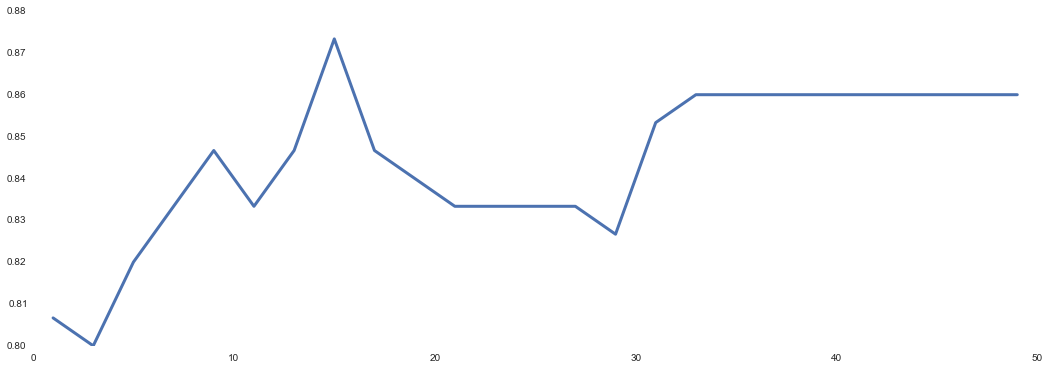

In [28]:
from sklearn import neighbors
#Loop through each neighbors value from 1 to 51 and append the scores
n_neighbors = range(1, 51, 2)
scores = []
for n in n_neighbors:
    clf = neighbors.KNeighborsClassifier(n)
    clf.fit(x_train, y_train)
    scores.append(clf.score(x_test, y_test))

plt.figure(figsize=(18,6))
_ = plt.plot(n_neighbors, scores, linewidth=3.0)

In [29]:
#Looks like n=15 is a good shot
n = 15
knn_clf = neighbors.KNeighborsClassifier(n)
knn_clf.fit(x_train, y_train)
print "Accuracy on the training data set using KNN = %0.2f" % (knn_clf.score(x_train, y_train)*100)
print "Accuracy on the test data set using KNN = %0.2f" % (knn_clf.score(x_test, y_test)*100)

Accuracy on the training data set using KNN = 86.29
Accuracy on the test data set using KNN = 87.33


Looks like KNN is not that bad either. But let's cross validate for KNN.

In [30]:
# Checking mean accuracy with Cross Validation on the test set using 10 Fold Cross Validation
scores = cross_val_score(knn_clf, x_test, y_test, cv=10)
print scores
print "Mean Accuracy on our overall data set using KNN = %0.2f" % (scores.mean()*100)

[ 0.8125      0.86666667  0.86666667  0.86666667  0.86666667  0.86666667
  0.86666667  0.86666667  0.86666667  0.85714286]
Mean Accuracy on our overall data set using KNN = 86.03


Pretty much in Synch with our Logistic Regression Results. Go with the Logistic Regression for the predictions.